Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE


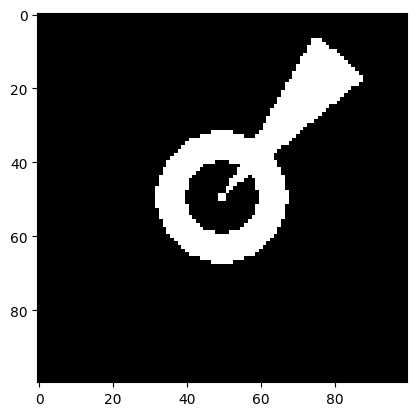

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import tensorflow as tf
# tf.config.threading.set_intra_op_parallelism_threads(10)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.set_visible_devices([], 'GPU')
from dpu_mini.fs_tools import *
from dpu_mini.mesh_maker import *
from dpu_mini.stats import *
import pandas as pd

dm_path = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/code/hypot_code/aps_pRF.mat'
dm_data = sio.loadmat(dm_path)
dm = dm_data['ApFrm']
plt.imshow(dm[:,:,51], cmap='gray')
# np.save('dm.npy', dm)

In [2]:
from nilearn.glm.first_level.design_matrix import create_cosine_drift
from nilearn.signal import clean
def highpass_dct(
    func,
    lb=0.01,
    TR=0.9,
    modes_to_remove=None,
    remove_constant=False,
):
    """highpass_dct

    Discrete cosine transform (DCT) is a basis set of cosine regressors of varying frequencies up to a filter cutoff of a specified number of seconds. Many software use 100s or 128s as a default cutoff, but we encourage caution that the filter cutoff isn't too short for your specific experimental design. Longer trials will require longer filter cutoffs. See this paper for a more technical treatment of using the DCT as a high pass filter in fMRI data analysis (https://canlab.github.io/_pages/tutorials/html/high_pass_filtering.html).

    Parameters
    ----------
    func: np.ndarray
        <n_voxels, n_timepoints> representing the functional data to be fitered
    lb: float, optional
        cutoff-frequency for low-pass (default = 0.01 Hz)
    TR: float, optional
        Repetition time of functional run, by default 0.9
    modes_to_remove: int, optional
        Remove first X cosines

    Returns
    ----------
    dct_data: np.ndarray
        array of shape(n_voxels, n_timepoints)
    cosine_drift: np.ndarray
        Cosine drifts of shape(n_scans, n_drifts) plus a constant regressor at cosine_drift[:, -1]

    Notes
    ----------
    * *High-pass* filters remove low-frequency (slow) noise and pass high-freqency signals.
    * Low-pass filters remove high-frequency noise and thus smooth the data.
    * Band-pass filters allow only certain frequencies and filter everything else out
    * Notch filters remove certain frequencies
    """
    # flatter first 3 dimention of func, keep the last dimention
    # Create high-pass filter and clean
    n_vol = func.shape[-1]
    ft = np.linspace(0 * TR, n_vol * TR, n_vol, endpoint=False)
    hp_set = create_cosine_drift(lb, ft)

    # select modes
    if isinstance(modes_to_remove, int):
        hp_set[:, :modes_to_remove]
    else:
        # remove constant column
        if remove_constant:
            hp_set = hp_set[:, :-1]

    dct_data = clean(func.T, detrend=True, standardize=True, confounds=hp_set).T

    return dct_data, hp_set

In [36]:
from dpu_mini.utils import *
import nibabel as nib
gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_mcalign/sub-hp01/ses-01'
gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_mcalign_notopup/sub-hp01/ses-01'
gii_files = os.listdir(gii_folder)
gii_files = [f for f in gii_files if '.gii' in f]
gii_files = [f for f in gii_files if 'SMOOTH' in f]

print(gii_files)
# bloop
# load as arrays LE & RE 
data = {}
for task in ['pRFLE', 'pRFRE']:
    t_files = [f for f in gii_files if task in f]
    hemi_data = {}
    for hemi in ['L', 'R']:
        tf = [f for f in t_files if f'hemi-{hemi}' in f]
        tdata = []
        for tgii in tf:
            tgii_nib = nib.load(opj(gii_folder, tgii))
            tgii_data = [i.data for i in tgii_nib.darrays]
            tgii_data = np.array(tgii_data)[4:,:] # drop first 4 trigger scans 
            tgii_data,_ = highpass_dct(tgii_data.T, TR=1.0, )
            # tgii_data = dag_detrending(tgii_data.T, detrend_param=2).T
            tdata.append(tgii_data.copy().T) 
        hemi_data[hemi] = np.mean(tdata, axis=0)
        print(hemi_data[hemi].shape)
        # tRf = [f for f in t_files if 'hemi-R' in f]
        # print(tL)   
    data[task] = pd.DataFrame(np.hstack([
        hemi_data['L'], hemi_data['R']
    ]))



['sub-hp01_ses-01_task-pRFRE_run-02_bold_space-fsnative_hemi-L_SMOOTHbold.func.gii', 'sub-hp01_ses-01_task-pRFRE_run-02_bold_space-fsnative_hemi-R_SMOOTHbold.func.gii', 'sub-hp01_ses-01_task-pRFRE_run-03_bold_space-fsnative_hemi-R_SMOOTHbold.func.gii', 'sub-hp01_ses-01_task-pRFRE_run-01_bold_space-fsnative_hemi-L_SMOOTHbold.func.gii', 'sub-hp01_ses-01_task-pRFRE_run-01_bold_space-fsnative_hemi-R_SMOOTHbold.func.gii', 'sub-hp01_ses-01_task-pRFRE_run-03_bold_space-fsnative_hemi-L_SMOOTHbold.func.gii']
()
()


/Users/marcusdaghlian/miniforge3/envs/tf_gpu001/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/marcusdaghlian/miniforge3/envs/tf_gpu001/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_27619/4157258929.py:53: FutureWarning: boolean values for 'standardize' will be deprecated in nilearn 0.15.0.
Use 'zscore_sample' instead of 'True' or use 'None' instead of 'False'.
  dct_data = clean(func.T, detrend=True, standardize=True, confounds=hp_set).T
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_27619/4157258929.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  dct_data = clean(func.T, detrend=True, standardize=True, confounds=hp_set

(348, 139218)


/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_27619/4157258929.py:53: FutureWarning: boolean values for 'standardize' will be deprecated in nilearn 0.15.0.
Use 'zscore_sample' instead of 'True' or use 'None' instead of 'False'.
  dct_data = clean(func.T, detrend=True, standardize=True, confounds=hp_set).T
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_27619/4157258929.py:53: DeprecationWarning: From release 0.14.0, confounds will be standardized using the sample std instead of the population std.
  dct_data = clean(func.T, detrend=True, standardize=True, confounds=hp_set).T
/var/folders/01/hhsk37310zsgzgg1nhgs6rfm0000gn/T/ipykernel_27619/4157258929.py:53: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.14.0, the default strategy will be replaced by the new strategy, the 'zscore

(348, 137925)


'pRFRE'

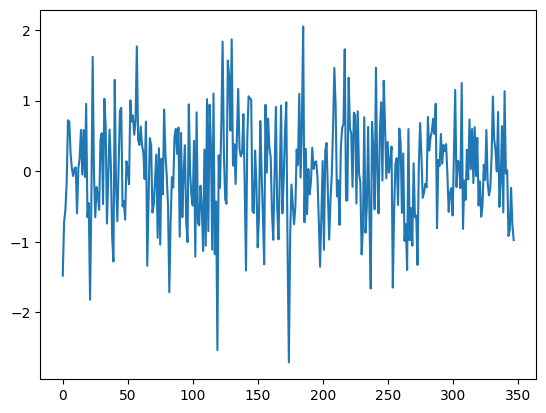

In [5]:
plt.plot(data[task].iloc[:,0])
task

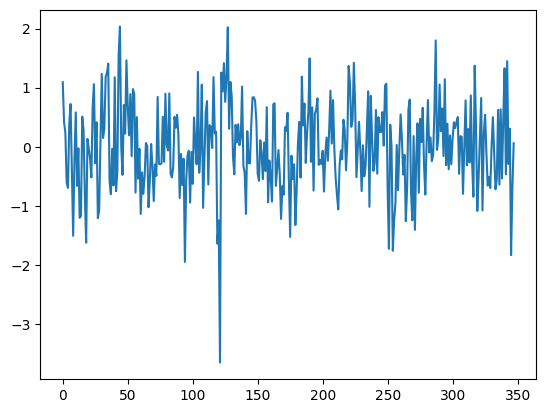

In [6]:

plt.plot(data[task].iloc[:,90])

In [7]:
fs_dir = '/Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer'
sub = 'sub-hp01'
v1 = dag_load_roi(sub, 'b14_V1', fs_dir, combine_matches=True)
v1_ts = data['pRFRE'].iloc[:,v1]

In [31]:
from scipy.signal import savgol_filter
v1_ts = savgol_filter(v1_ts, window_length=12, polyorder=3, axis=0)
v1_ts = pd.DataFrame(v1_ts)
# v1_ts.iloc[:5,:] = 0
# print(v1_ts.iloc[5:,:])
# v1_ts.iloc[-5:,:] = 0

In [ ]:
v1_ts.shape

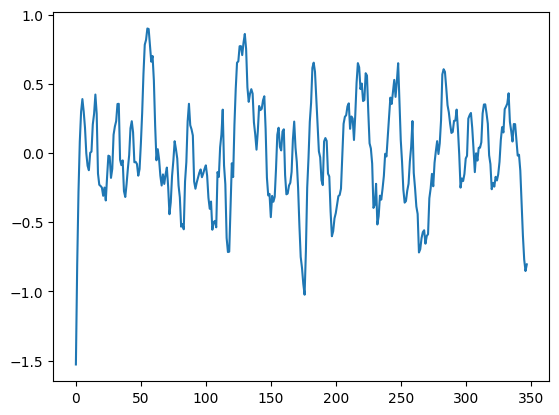

In [32]:
plt.plot(v1_ts.iloc[:,0])

In [ ]:
v1_ts = (data['pRFLE'] + data['pRFRE'])/ 2
v1_ts

In [ ]:
a = dag_row_wise_corr(
    data['pRFLE'].to_numpy().T, 
    data['pRFRE'].to_numpy().T, 
)

In [ ]:
m.flat_mpl(data=a, vmin=-.1, vmax=.1, cmap='RdBu')

In [ ]:
fig, axs = plt.subplots(12,29)
axs = axs.flatten()
for i in range(348):
    axs[i].imshow(dm[:,:,i])
    axs[i].axis('off')


In [ ]:
348 / 12

In [33]:
from braincoder.optimize import *
from braincoder.models import GaussianPRF2DWithHRF, ContrastSensitivityWithHRF, DifferenceOfGaussiansPRF2DWithHRF, DivisiveNormalizationGaussianPRF2DWithHRF, CompressiveSpatialGaussiansPRF2DWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel
# dm = np.load('dm.npy')

paradigm = np.rollaxis(dm, 2, 0) # time; x ; y
radius_vert = 21.5
radius_horiz = 21.5
tr = 1.0
x_grid, y_grid = np.meshgrid(
    np.linspace(-radius_horiz, radius_horiz, dm.shape[1]),
    np.linspace(-radius_vert, radius_vert, dm.shape[0])
    )
y_grid *= -1

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

# Create the model using the loaded HRF parameter from the YAML config
model = GaussianPRF2DWithHRF(
    grid_coordinates, 
    paradigm=paradigm,
    hrf_model=SPMHRFModel(tr=tr), 
    flexible_hrf_parameters=False,
    )        

#     model = DivisiveNormalizationGaussianPRF2DWithHRF(
#         grid_coordinates, 
#         paradigm=paradigm,
#         hrf_model=SPMHRFModel(tr=dm.TR), 
#         flexible_hrf_parameters=flexible_hrf_parameters,
#         )                    

#     model = DifferenceOfGaussiansPRF2DWithHRF(
#         grid_coordinates, 
#         paradigm=paradigm,
#         hrf_model=SPMHRFModel(tr=dm.TR), 
#         flexible_hrf_parameters=flexible_hrf_parameters,
#         )     

#     model = CompressiveSpatialGaussiansPRF2DWithHRF(
#         grid_coordinates, 
#         paradigm=paradigm,
#         hrf_model=SPMHRFModel(tr=dm.TR), 
#         flexible_hrf_parameters=flexible_hrf_parameters,
#         )                                            


cfitter = ParameterFitter(
    model, v1_ts, model.paradigm,
    # memory_limit=666666666//10
    )    



In [ ]:
dm.shape

In [ ]:
paradigm.shape

In [ ]:
pars = {
    'x' : np.array([-20,20,3]),
    'y' : np.array([-20,20,3]), 
    'sd' : np.array([10,1,2]),
    'baseline' : np.array([0.0, 0.0, 0.0, ]), 
    'amplitude' : np.array([10, 10, 10, ]),
    'hrf_delay' : np.array([1.0, 1.0, 1.0]),
    'hrf_dispersion' : np.array([1.0, 1.0, 1.0]),
}
import pandas as pd 
pars = pd.DataFrame(pars)
pars
a = model.predict(parameters=pars)
plt.plot(a.iloc[:,0])
plt.plot(a.iloc[:,1])

In [34]:

bounds       = {
    'x' : [-20, 20], 
    'y' : [-20, 20], 
    'sd': [.1, 20], 
    # ''
}
grid_points = 20


# min_hrf_delay=3., max_hrf_delay=7.0,
#              min_dispersion=0.3, max_dispersion=2.0):
# hrf_kwargs = {
#     'hrf_delay' : np.linspace(3.1,6.5,5), # np.array([1.0]), 
#     'hrf_dispersion' : np.linspace(0.4,1.9,5), #np.array([1.0]), 
# }
grid_pars = cfitter.fit_grid(
    x       = np.linspace(bounds['x'][0], bounds['x'][1], 20),
    y       = np.linspace(bounds['y'][0], bounds['y'][1], 20),
    sd      = np.linspace(bounds['sd'][0], bounds['sd'][1], 20),
    amplitude   = [1.0],
    baseline    = [0.0],
    use_correlation_cost = True, 
    # **hrf_kwargs
)
grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars, l2_alpha=0.0)    
r2 = cfitter.get_rsq(parameters=grid_pars)
print(r2.mean())

Working with chunk size of 252
Using correlation cost!


100%|██████████| 32/32 [00:04<00:00,  7.18it/s]


0.05079364


,x,y,sd,baseline,amplitude,hrf_delay,hrf_dispersion
source,,,,,,,
0,3.157895,1.052632,1.147368,-0.027673,0.580125,3.1,0.4
1,-1.052632,-1.052632,0.100000,0.000000,1.000000,3.1,0.4
8,-1.052632,-1.052632,0.100000,0.000000,1.000000,3.1,0.4
9,-1.052632,-1.052632,0.100000,0.000000,1.000000,3.1,0.4
13,-1.052632,-1.052632,0.100000,0.000000,1.000000,3.1,0.4
...,...,...,...,...,...,...,...
277035,5.263158,17.894737,0.100000,0.000000,1.000000,6.5,1.9
277077,-1.052632,1.052632,1.147368,-0.064957,1.081526,3.1,0.4
277080,-5.263158,3.157895,2.194737,-0.080926,0.932668,6.5,1.9


In [35]:
np.nanargmax(r2.to_numpy())

7009

In [30]:
(r2>0.1).sum()

0

In [12]:
preds = model.predict(parameters=grid_pars)

In [ ]:
grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars)    

In [ ]:
preds = model.predict(parameters=grid_pars)

In [ ]:
r2.argmax()

1951


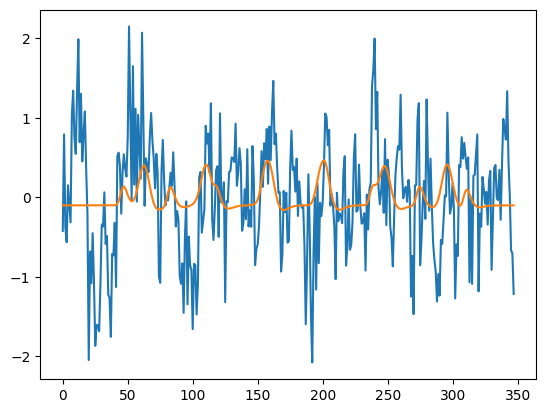

In [14]:
print(r2.argmax())
plt.plot(v1_ts.iloc[:,1951])
plt.plot(preds.iloc[:,1951])

In [ ]:
iter_pars3 = cfitter.fit(
    init_pars=iter_pars2, 
    learning_rate=0.1,
    max_n_iterations=50,
)

In [ ]:
plt.scatter(
    iter_pars3['x'], 
    iter_pars3['y']
)

In [ ]:
m.flat_mpl(
    data=iter_pars3['y'],
    data_sub_mask=v1, 
    vmin=-5, vmax=5, cmap='RdBu'
)

In [ ]:
iter_pars2 = cfitter.refine_baseline_and_amplitude(iter_pars2)    

In [ ]:
ecc = np.sqrt(iter_pars['x']**2 + iter_pars['y']**2)

In [ ]:
m.flat_mpl(
    data=ecc, #iter_pars['y'], 
    data_sub_mask=v1, 
    vmin=0, vmax=20, 
    data_mask
)

In [ ]:
from dpu_mini.mesh_maker import *
m = GenMeshMaker(
    sub='sub-hp01', fs_dir=fs_dir,
)

In [ ]:
sub = 'sub-hp01'
cb = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)

m.make_flat_map(centre_bool=cb)

In [ ]:
m.flat_mpl(
    data=iter_pars['x'], 
    vmin=-5.0, vmax=5.0, 
    data_sub_mask=v1
)

In [ ]:
r2

In [ ]:
!pip install scikit-learn 

In [ ]:
    grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars)    
    r2 = cfitter.get_rsq(parameters=grid_pars)
    pkl2save = {
        'config' : config, 
        'pars' : grid_pars, 
        'stage' : 'grid', 
        'r2' : r2, 
        'name' : grid_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(grid_out, 'wb') as file:
        pickle.dump(pkl2save, file)
else:
    print(grid_out_all)
    try: 
        with open(grid_out_all, 'rb') as file:
            grid_pars_full = pickle.load(file)['pars']
            grid_pars = grid_pars_full.iloc[roi_mask,:]
    except:
        with open(grid_out, 'rb') as file:
            grid_pars = pickle.load(file)['pars']
if grid_only:
    print('ONLY RUNNING GRID STAGE')
    sys.exit()
print(psc_ts_mask.shape)
print(psc_ts_mask)
# Iterative stage         
iter_out = opj(output_path, f'{sub}_ses-{eye}_task-pRF_model-gauss_stage-iter_roi-{roi}{id}.pkl')
if (not os.path.exists(iter_out)) | ow:
    if fit_hrf:
        grid_pars['hrf_delay'] = 6.0
        grid_pars['hrf_dispersion'] = 1.0
    # grid_pars to float 16 
    grid_pars = grid_pars.astype(np.float16)
    iter_pars = cfitter.fit(
        init_pars=grid_pars, 
        max_n_iterations=config['gauss']['num_steps'], 
        fixed_pars=config['gauss']['fixed_pars'],
        )        
    r2 = cfitter.get_rsq(parameters=iter_pars)
    pkl2save = {
        'config' : config, 
        'pars' : iter_pars, 
        'stage' : 'iter', 
        'r2' : r2, 
        'name' : iter_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(iter_out, 'wb') as file:
        pickle.dump(pkl2save, file)

In [ ]:
!pip install nibabel

In [ ]:
pars = {
    'x' : np.array([-5,5,3]),
    'y' : np.array([-5,5,3]), 
    'sd' : np.array([1,1,2]),
    'baseline' : np.array([0.0, 0.0, 0.0, ]), 
    'amplitude' : np.array([10, 10, 10, ]),
}
import pandas as pd 
pars = pd.DataFrame(pars)
pars
a = model.predict(parameters=pars)
plt.plot(a.iloc[:,0])
plt.plot(a.iloc[:,1])